In [1]:
## importing labiary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## importing data 
file_path='billing.xlsx'

#loading eacch sheet
df_jan=pd.read_excel(file_path,sheet_name='Jan')
df_feb=pd.read_excel(file_path,sheet_name='Feb')
df_mar=pd.read_excel(file_path,sheet_name='March')
df_client_rates=pd.read_excel(file_path,sheet_name='Rates - Clients')
df_vendor_rates=pd.read_excel(file_path,sheet_name='Rates - Carrier')

print("data loaded succefully!")


data loaded succefully!


In [3]:
# Combine the monthly billing data into a single DataFrame
df_billing = pd.concat([df_jan, df_feb, df_mar], ignore_index=True)

# Display the number of rows and columns to confirm the data was combined
print(f"Combined DataFrame shape: {df_billing.shape}")

Combined DataFrame shape: (108104, 4)


In [7]:

#merge the billing data with the client rates 
df_billing = pd.merge(df_billing,df_client_rates, on='Account ID (phone mumber)',how='left')

#merge the billing data with the vendor rates 
df_billing = pd.merge(df_billing,df_vendor_rates, on='Account ID (phone mumber)',how='left')

# print the colums to confirm the new rate coulmns have been added
print(df_billing.columns)


Index(['Customer', 'Account ID (phone mumber)', 'Duration (Seconds)',
       'Called From', 'Country_x', 'Number Type_x', 'LandLine Rate_x',
       'Mobile Rate_x', 'Vendor', 'Country_y', 'Number Type_y',
       'LandLine Rate_y', 'Mobile Rate_y'],
      dtype='object')


In [8]:
# Display the number of rows and columns to confirm the data was combined
print(f"Combined DataFrame shape: {df_billing.shape}")

# Check for rows in the billing data that don't have a matching client rate
missing_client_rates = df_billing[df_billing['LandLine Rate_x'].isnull() | df_billing['Mobile Rate_x'].isnull()]

if not missing_client_rates.empty:
    print("\nWARNING: The following calls have no matching client rates:")
    print(missing_client_rates[['Customer', 'Account ID (phone mumber)']].head())
    print(f"Total number of calls with missing client rates: {len(missing_client_rates)}")
else:
    print("\nAll calls have a matching client rate. Data is consistent.")

# Check for rows in the billing data that don't have a matching vendor rate
missing_vendor_rates = df_billing[df_billing['LandLine Rate_y'].isnull() | df_billing['Mobile Rate_y'].isnull()]

if not missing_vendor_rates.empty:
    print("\nWARNING: The following calls have no matching vendor rates:")
    print(missing_vendor_rates[['Customer','Account ID (phone mumber)']].head())
    print(f"Total number of calls with missing vendor rates: {len(missing_vendor_rates)}")
else:
    print("\nAll calls have a matching vendor rate. Data is consistent.")

Combined DataFrame shape: (108104, 13)

      Customer  Account ID (phone mumber)
18324      NaN                        NaN
18325      NaN                        NaN
18326      NaN                        NaN
18327      NaN                        NaN
18328      NaN                        NaN
Total number of calls with missing client rates: 35982

      Customer  Account ID (phone mumber)
18324      NaN                        NaN
18325      NaN                        NaN
18326      NaN                        NaN
18327      NaN                        NaN
18328      NaN                        NaN
Total number of calls with missing vendor rates: 35982


In [9]:
# filling the missing rates values with 0.0
df_billing['LandLine Rate_x'].fillna(0.0, inplace=True)
df_billing['Mobile Rate_x'].fillna(0.0, inplace=True)
df_billing['Mobile Rate_y'].fillna(0.0, inplace=True)
df_billing['LandLine Rate_y'].fillna(0.0, inplace=True)

In [10]:
# Calculate client billing duration in minutes (rounded up)
df_billing['client_billable_minutes'] = np.ceil(df_billing['Duration (Seconds)'] / 60)

# Calculate revenue based on number type and client rates
# Assuming 'number type' is in df_client_rates after the merge
df_billing['revenue'] = df_billing.apply(
    lambda row: row['client_billable_minutes'] * row['LandLine Rate_x'] if row['Number Type_x'] == 'LandLine'
    else row['client_billable_minutes'] * row['Mobile Rate_x'], axis=1
)

print("Revenue calculated successfully.")
print(df_billing[['Duration (Seconds)', 'client_billable_minutes', 'Number Type_x', 'revenue']].head())


Revenue calculated successfully.
   Duration (Seconds)  client_billable_minutes Number Type_x  revenue
0               114.0                      2.0           DID      0.2
1                72.0                      2.0           DID      0.2
2               231.0                      4.0           DID      0.4
3                67.0                      2.0           DID      0.2
4                52.0                      1.0           DID      0.1


In [11]:
# Function to calculate cost based on vendor billing rules
def calculate_cost(row):
    vendor = row['Vendor']
    duration_seconds = row['Duration (Seconds)']
    # selecting rate based on vendor number type column
    if row['Number Type_y']=='LandLine':
        rate=row['LandLine Rate_y']
    else:
        rate=row['Mobile Rate_y']

    if vendor == 'Vendor 1':
        # Bill every 6 seconds.
        billable_units = np.ceil(duration_seconds / 6)
        cost = billable_units * rate
    elif vendor == 'Vendor 2':
        # Per second billing.
        cost = duration_seconds * rate
    elif vendor == 'Vendor 3':
        # Per minute billing.
        billable_units = np.ceil(duration_seconds / 60)
        cost = billable_units * rate
    elif vendor == 'Vendor 4':
        # First 30 seconds, then every 6 seconds.
        if duration_seconds <= 30:
            cost = 30 * rate # Bill for 30 seconds
        else:
            billable_units = np.ceil((duration_seconds - 30) / 6)
            cost = (30 + billable_units * 6) * rate
    elif vendor == 'Vendor 5':
        # Every 30 seconds.
        billable_units = np.ceil(duration_seconds / 30)
        cost = billable_units * rate
    else:
        cost = 0  # Handle unknown vendors

    return cost

In [12]:
# Apply the cost calculation function to each row
df_billing['cost'] = df_billing.apply(calculate_cost, axis=1)

print("\nCost calculated successfully.")
print(df_billing[['Vendor', 'Duration (Seconds)', 'cost']].head())

# ---

# Create a new column for gross margin in dollar value
df_billing['gross_margin_dollars'] = df_billing['revenue'] - df_billing['cost']

# Total billing (revenue) per client
total_billing_per_client = df_billing.groupby('Customer')['revenue'].sum().reset_index()
print("Total Billing per Client:\n")
print(total_billing_per_client.head())

# Gross Margin by Client in % form
gross_margin_by_client = df_billing.groupby('Customer').apply(
    lambda x: (x['gross_margin_dollars'].sum() / x['revenue'].sum()) * 100
).to_frame('gross_margin_percent').reset_index()
print("\nGross Margin by Client (%):\n")
print(gross_margin_by_client.head())


Cost calculated successfully.
     Vendor  Duration (Seconds)  cost
0  Vendor 5               114.0  0.28
1  Vendor 5                72.0  0.21
2  Vendor 5               231.0  0.56
3  Vendor 5                67.0  0.21
4  Vendor 5                52.0  0.14
Total Billing per Client:

     Customer    revenue
0    Client 1   3358.442
1  Client 10   13360.500
2  Client 11      97.600
3  Client 12     101.300
4  Client 13       9.450

Gross Margin by Client (%):

     Customer  gross_margin_percent
0    Client 1          -1372.523849
1  Client 10            -425.724992
2  Client 11              28.739754
3  Client 12           -1045.700888
4  Client 13               6.666667


In [13]:
# Calculate total values for the entire billing period
total_revenue = df_billing['revenue'].sum()
total_cost = df_billing['cost'].sum()
total_gross_margin = df_billing['gross_margin_dollars'].sum()
overall_gross_margin_percent = (total_gross_margin / total_revenue) * 100

print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Cost: ${total_cost:,.2f}")
print(f"Total Gross Margin: ${total_gross_margin:,.2f}")
print(f"Overall Gross Margin Percentage: {overall_gross_margin_percent:.2f}%")

Total Revenue: $127,294.19
Total Cost: $2,386,496.26
Total Gross Margin: $-2,259,202.07
Overall Gross Margin Percentage: -1774.79%


In [14]:
# Group data by vendor and calculate total revenue, cost, and margin
vendor_performance = df_billing.groupby('Vendor').agg(
    total_revenue=('revenue', 'sum'),
    total_cost=('cost', 'sum'),
    gross_margin_dollars=('gross_margin_dollars', 'sum')
).reset_index()

# Calculate gross margin percentage for each vendor
vendor_performance['gross_margin_percent'] = (
    vendor_performance['gross_margin_dollars'] / vendor_performance['total_revenue']
) * 100

print("\nPerformance by Vendor:")
print(vendor_performance)


Performance by Vendor:
     Vendor  total_revenue    total_cost  gross_margin_dollars  \
0  Vendor 1      46728.136  3.070166e+05         -2.602885e+05   
1  Vendor 2      11039.060  3.937186e+05         -3.826796e+05   
2  Vendor 3      17371.221  9.858966e+03          7.512255e+03   
3  Vendor 4      43209.601  1.671218e+06         -1.628009e+06   
4  Vendor 5       8946.171  4.683664e+03          4.262506e+03   

   gross_margin_percent  
0           -557.027291  
1          -3466.595686  
2             43.245403  
3          -3767.701493  
4             47.646155  


In [27]:
# total cost per vendor 
total_vendor_cost=df_billing.groupby('Vendor')['cost'].sum()

In [15]:
# Calculate total values for the entire billing period
total_revenue = df_billing['revenue'].sum()
total_cost = df_billing['cost'].sum()
total_gross_margin = df_billing['gross_margin_dollars'].sum()
overall_gross_margin_percent = (total_gross_margin / total_revenue) * 100

print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Cost: ${total_cost:,.2f}")
print(f"Total Gross Margin: ${total_gross_margin:,.2f}")
print(f"Overall Gross Margin Percentage: {overall_gross_margin_percent:.2f}%")

Total Revenue: $127,294.19
Total Cost: $2,386,496.26
Total Gross Margin: $-2,259,202.07
Overall Gross Margin Percentage: -1774.79%


In [16]:
# Group data by vendor and calculate total revenue, cost, and margin
vendor_performance = df_billing.groupby('Vendor').agg(
    total_revenue=('revenue', 'sum'),
    total_cost=('cost', 'sum'),
    gross_margin_dollars=('gross_margin_dollars', 'sum')
).reset_index()

# Calculate gross margin percentage for each vendor
vendor_performance['gross_margin_percent'] = (
    vendor_performance['gross_margin_dollars'] / vendor_performance['total_revenue']
) * 100

print("\nPerformance by Vendor:")
print(vendor_performance)


Performance by Vendor:
     Vendor  total_revenue    total_cost  gross_margin_dollars  \
0  Vendor 1      46728.136  3.070166e+05         -2.602885e+05   
1  Vendor 2      11039.060  3.937186e+05         -3.826796e+05   
2  Vendor 3      17371.221  9.858966e+03          7.512255e+03   
3  Vendor 4      43209.601  1.671218e+06         -1.628009e+06   
4  Vendor 5       8946.171  4.683664e+03          4.262506e+03   

   gross_margin_percent  
0           -557.027291  
1          -3466.595686  
2             43.245403  
3          -3767.701493  
4             47.646155  


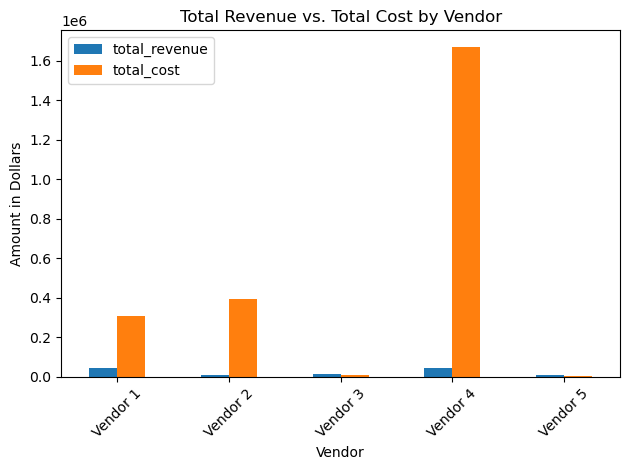

In [17]:
# Plot total revenue and cost by vendor
vendor_performance.set_index('Vendor')[['total_revenue', 'total_cost']].plot(kind='bar')
plt.title('Total Revenue vs. Total Cost by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Amount in Dollars')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
#  Gross margin by CLIENT 
gm_client = df_billing.groupby('Customer').agg(
    revenue=('revenue', 'sum'),
    cost=('cost', 'sum')
).reset_index()
gm_client['gross_margin_percent'] = ((gm_client['revenue'] - gm_client['cost']) / gm_client['revenue']) * 100

In [36]:
#  Gross margin by COUNTRY 
gm_country = df_billing.groupby('Country_x').agg(
    revenue=('revenue', 'sum'),
    cost=('cost', 'sum')
).reset_index()
gm_country['gross_margin_percent'] = ((gm_country['revenue'] - gm_country['cost']) / gm_country['revenue']) * 100

In [35]:
#  Gross margin by CARRIER (VENDOR)
gm_carrier = df_billing.groupby('Vendor').agg(
    revenue=('revenue', 'sum'),
    cost=('cost', 'sum')
).reset_index()
gm_carrier['gross_margin_percent'] = ((gm_carrier['revenue'] - gm_carrier['cost']) / gm_carrier['revenue']) * 100


In [34]:
#  Gross margin by NUMBER TYPE
gm_numbertype = df_billing.groupby('Number Type_x').agg(
    revenue=('revenue', 'sum'),
    cost=('cost', 'sum')
).reset_index()
gm_numbertype['gross_margin_percent'] = ((gm_numbertype['revenue'] - gm_numbertype['cost']) / gm_numbertype['revenue']) * 100

In [24]:
#  Scenario modeling: +7% Mobile, +20% Landline 
def apply_rate_increase(df, mobile_increase=0.07, landline_increase=0.20):
    df = df.copy()
    df['new_revenue'] = df.apply(
        lambda x: x['revenue'] * (1 + mobile_increase) if x['Number Type_x'] == 'Mobile'
        else x['revenue'] * (1 + landline_increase),
        axis=1
    )
    return df

scenario = apply_rate_increase(df_billing)
total_rev_scenario = scenario['new_revenue'].sum()
total_cost_scenario = scenario['cost'].sum()
gm_new = ((total_rev_scenario - total_cost_scenario) / total_rev_scenario) * 100
print(f"Gross Margin after +7% mobile / +20% landline: {gm_new:.2f}%")

Gross Margin after +7% mobile / +20% landline: -1462.32%


In [47]:
# preparing scenario result as a dataframe
Scenario=pd.DataFrame({
    'Metric':['Gross Margin after +7%/+20%'],
    'value':[gm_new]
})

In [25]:
#  Find single rate increase needed to hit 45% GM 
def margin_for_multiplier(mult):
    df = df_billing.copy()
    df['new_revenue'] = df['revenue'] * (1 + mult)
    total_rev = df['new_revenue'].sum()
    total_cost = df['cost'].sum()
    return ((total_rev - total_cost) / total_rev) * 100

for m in np.arange(0, 1.1, 0.01):
    gm = margin_for_multiplier(m)
    if gm >= 45:
        print(f"Uniform rate increase required: {m*100:.1f}% to reach {gm:.1f}% gross margin")
        break

In [31]:
## Gross margin by country/country/client
gm_ccc=(
df_billing.groupby(['Country_x','Vendor','Customer']).apply(lambda g:(g['revenue'].sum()-g['cost'].sum())/g['revenue'].sum()
                                                            *100)

).reset_index(name='Gross_margin_%')

In [38]:
# getting 45% gross margin
#Calculate current totals
current_revenue = df_billing['revenue'].sum()  
current_cost = df_billing['cost'].sum()  

# Desired gross margin target
target_margin = 0.45

# Calculate required revenue to hit 45% margin
required_revenue = current_cost / (1 - target_margin)

# Calculate multiplier on client rates
rate_multiplier = required_revenue / current_revenue

print(f"Current Gross Margin: {((current_revenue - current_cost)/current_revenue)*100:.2f}%")
print(f"Required Revenue: {required_revenue:,.2f}")
print(f"Rate Multiplier to hit 45% GM: {rate_multiplier:.3f} (i.e., increase client rates by {(rate_multiplier-1)*100:.1f}%)")

Current Gross Margin: -1774.79%
Required Revenue: 4,339,084.11
Rate Multiplier to hit 45% GM: 34.087 (i.e., increase client rates by 3308.7%)


In [55]:
# preparing gross margin at 25 percent as dataframe
gm_45=pd.DataFrame({
    'current_gross_margin':[((current_revenue - current_cost)/current_revenue)*100],
    'required revenue':[required_revenue],
    'rate multiplier':[rate_multiplier],
    'Increase_%':[(rate_multiplier-1)*100]
})

In [57]:
# group by vendor and sum cost
Total_vendor_cost =df_billing.groupby('Vendor')['cost'].sum().reset_index()

#rename the column for clarity 
Total_vendor_cost.rename(columns={'cost':'Total cost'},inplace= True)
print(Total_vendor_cost )

     Vendor    Total cost
0  Vendor 1  3.070166e+05
1  Vendor 2  3.937186e+05
2  Vendor 3  9.858966e+03
3  Vendor 4  1.671218e+06
4  Vendor 5  4.683664e+03


In [64]:
#  Clean column names to avoid confusion ---
df_billing = df_billing.rename(columns={
    'Country_x': 'Client_Country',
    'Number Type_x': 'Client_NumberType',
    'LandLine Rate_x': 'Client_LandlineRate',
    'Mobile Rate_x': 'Client_MobileRate',
    'Country_y': 'Vendor_Country',
    'Number Type_y': 'Vendor_NumberType',
    'LandLine Rate_y': 'Vendor_LandlineRate',
    'Mobile Rate_y': 'Vendor_MobileRate'
})

In [65]:
#Export everything to one Excel file
with pd.ExcelWriter('avoxi_analysis_results.xlsx', engine='openpyxl') as writer:
    total_billing_per_client.to_excel(writer, sheet_name='Total Billing per Client', index=False)
    gm_client.to_excel(writer, sheet_name='Margin by Client', index=False)
    gm_country.to_excel(writer, sheet_name='Margin by Country', index=False)
    gm_carrier.to_excel(writer, sheet_name='Margin by Carrier', index=False)
    gm_numbertype.to_excel(writer, sheet_name='Margin by Number Type', index=False)
    Total_vendor_cost.to_excel(writer, sheet_name='Cost per Vendor', index=False)
    gm_ccc.to_excel(writer, sheet_name='Margin by Country-Carrier-Client', index=False)
    Scenario.to_excel(writer, sheet_name='Scenario +7% +20%', index=False)
    gm_45.to_excel(writer, sheet_name='Target 45% Gross Margin', index=False)
print("All results exported successfully to avoxi_analysis_results.xlsx")

All results exported successfully to avoxi_analysis_results.xlsx
